In [21]:
# AIR: use the mdanalysis environment

import pandas as pd
import numpy as np
import deeptime as dt
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm
import os

In [22]:


traj_list=utils.read_traj_list()

In [23]:
models = []
cthr = 5
#lagtimes = [1,10,20,30,60,100,200,300]
lagtimes = np.arange(20, 400, 20)
for lagtime in tqdm(lagtimes):
    tcm = dt.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='sliding').fit_fetch(traj_list)
    tcm_fix = tcm.count_matrix.copy()
    tcm_fix[tcm_fix<cthr] = 0
    tcm = dt.markov.TransitionCountModel(tcm_fix, lagtime=lagtime)
    #counts = counts.submodel_largest(connectivity_threshold=cthr)
    #mod=dt.markov.msm.BayesianMSM(n_samples=50).fit(counts,ignore_counting_mode=True).fetch()
    mod=dt.markov.msm.MaximumLikelihoodMSM().fit_fetch(tcm)
    models.append(mod)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


In [24]:
tcm_fix=dt.markov.TransitionCountEstimator(lagtime=200,count_mode='sliding').fit_fetch(traj_list)




Text(0, 0.5, 'timescale (steps)')

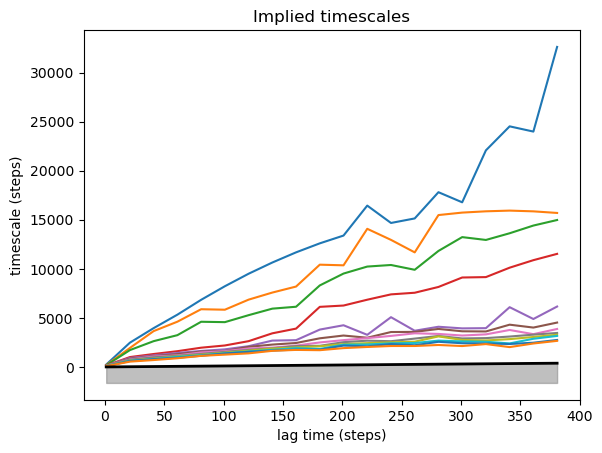

In [25]:
its_data = dt.util.validation.implied_timescales(models)

fig, ax = plt.subplots(1, 1)
dt.plots.plot_implied_timescales(its_data, n_its=12, ax=ax)
#ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')



# PCCA

In [26]:
chosen_lagtime = 350
chosen_model_idx = utils.index_of_closest(lagtimes, chosen_lagtime)
chosen_model = models[chosen_model_idx]

print(f"Number of states: {chosen_model.n_states}")


Number of states: 399


In [27]:
n_macro=6
pcca = chosen_model.pcca(n_metastable_sets=n_macro)


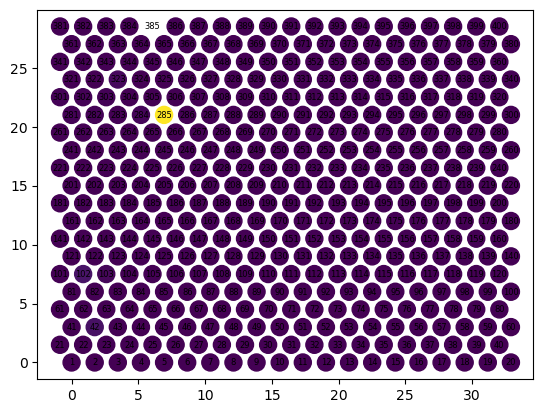

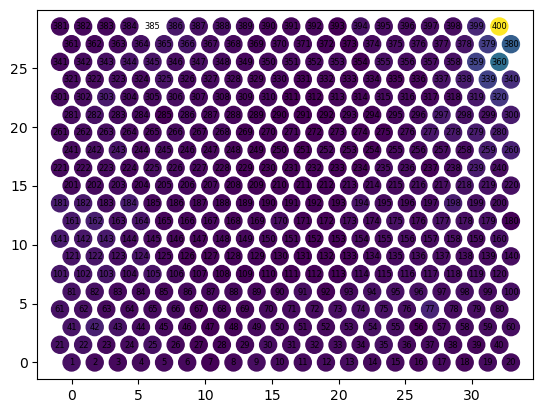

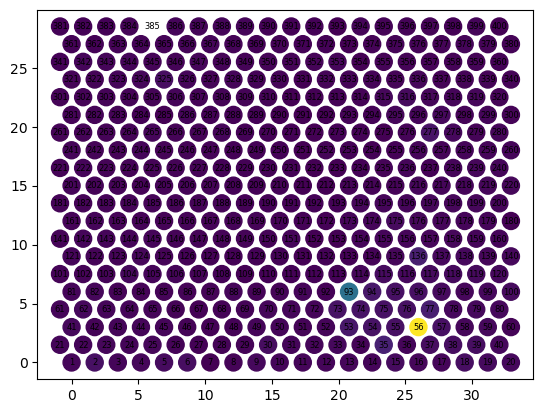

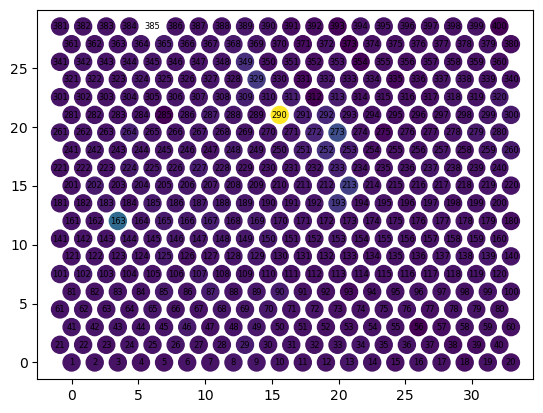

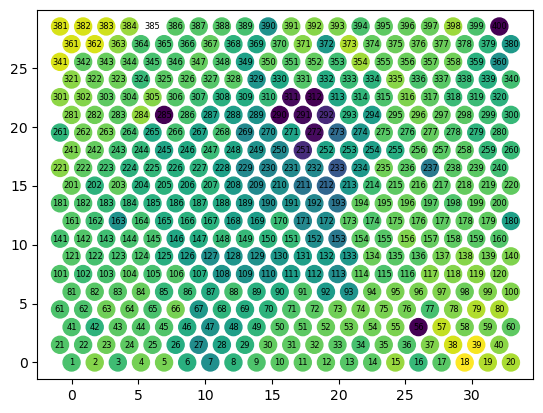

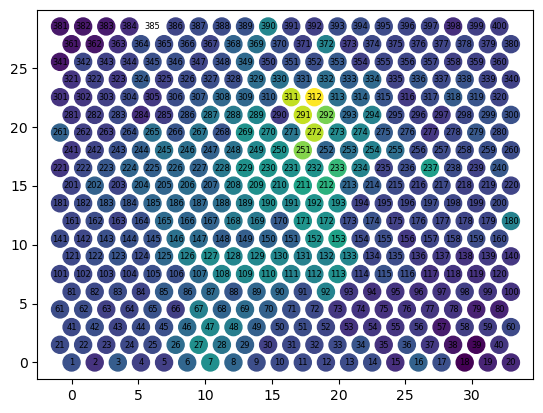

In [28]:
hgrid = utils.hexagonal_grid(20,20)
for m in range(n_macro):
    utils.state_plot(hgrid, pcca.memberships[:,m], chosen_model)
    plt.show()

[0.00109079 0.0171346  0.01838566 0.09288843 0.27576076 0.59473976]


Text(0.5, 0, 'Macrostate')

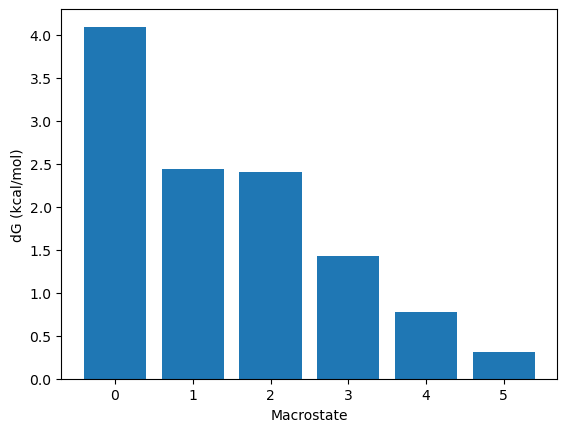

In [29]:
print(pcca.coarse_grained_stationary_probability)
plt.bar(range(n_macro),
        -.6*np.log(pcca.coarse_grained_stationary_probability))
plt.ylabel("dG (kcal/mol)")
plt.xlabel("Macrostate")

Bound state: 291 311 272

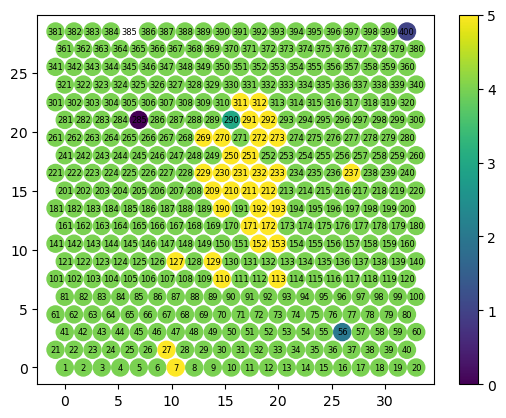

In [30]:
utils.state_plot(hgrid, pcca.assignments, chosen_model)
plt.colorbar()

# Bayesian

In [31]:
# Bayesian estimation (slow)

bayesian_estimator = dt.markov.msm.BayesianMSM(
    n_samples=100,
    n_steps=10,
    reversible=True,
    stationary_distribution_constraint=None
)
bayesian_counts = dt.markov.TransitionCountEstimator(lagtime=chosen_lagtime, count_mode="effective").fit(traj_list).fetch_model()
bayesian_model = bayesian_estimator.fit(bayesian_counts).fetch_model()
